In [20]:
import sys
sys.path.append("..")

from utils import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import ppscore as pps
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
import sklearn.metrics
from feature_engine import categorical_encoders as ce
from feature_engine import variable_transformers as vt
from scipy.stats import skew, norm

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import RFECV
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import power_transform
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, RidgeCV
    

warnings.simplefilter("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Steps: 
- Natural Log Normalize House Price -> then turn back after prediction
- Combine temporal variables (remove garage as it can be detected from hasGarage)
- Missing Values -> Fill with Missing, except for PoolQC, Alley etc change to binary
- Categorical to dummy variables

### Read Data

In [3]:
train = pd.read_csv("../data/train.csv", index_col = [0])
test = pd.read_csv("../data/test.csv", index_col = [0])

### Group Each Variables

In [4]:
temporal_old = [var for var in train.columns \
            if ("Yr" in var) \
            or ("Mo" in var) \
            or ("Year" in var)]


levels = ["OverallCond", "OverallQual", "BsmtFullBath", 
          "BsmtHalfBath", "FullBath", "HalfBath", 
          "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", 
          "Fireplaces", "GarageCars", "ExterQual", 
          "ExterCond", "BsmtQual", "BsmtCond", 
          "BsmtExposure", "HeatingQC", "KitchenQual", 
          "GarageQual","GarageCond", "ExterQual",
          "ExterCond", "BsmtQual", "BsmtCond", 
          "BsmtExposure","HeatingQC", "PoolQC", 
          "KitchenQual", "GarageQual","GarageCond", 
          "FireplaceQu", 'hasPool', 'has2ndfloor', 
          'hasGarage', 'hasBsmt', 'hasFireplace']

categorical = [var for var in train.columns \
               if (train[var].dtype =='O') 
               and (var not in temporal_old)
               and (var not in levels)] + ["MSSubClass"]

numerical = [var for var in train.columns \
             if (train[var].dtype !='O') 
             and (var not in temporal_old) 
             and (var not in levels) 
             and (var != "SalePrice") 
             and (var != "MSSubClass")]

numerical_level = levels + numerical

### Convert Group to Rankings 

In [5]:
## categorical to levels conversion

def create_n_fix_variables(train):
    
    # change ranked variable to not be included in categorical encoding
    train["ExterQual"]    = train["ExterQual"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
    train["ExterCond"]    = train["ExterCond"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
    train["BsmtQual"]     = train["BsmtQual"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
    train["BsmtCond"]     = train["BsmtCond"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
    train["BsmtExposure"] = train["BsmtExposure"].map({"None": 0, "No": 1, "Mn":2, "Av":3, "Gd":4})
    train["HeatingQC"]    = train["HeatingQC"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
    train["PoolQC"]       = train["PoolQC"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
    train["KitchenQual"]  = train["KitchenQual"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
    train["GarageQual"]   = train["GarageQual"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
    train["GarageCond"]   = train["GarageCond"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
    train["FireplaceQu"]  = train["FireplaceQu"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})

    ## convert MSSubclass to categorical
    train["MSSubClass"] = train["MSSubClass"].astype(str)
    
    ## change some of sparse variables to binary
    train['hasPool'] = train['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    train['has2ndfloor'] = train['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    train['hasGarage'] = train['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    train['hasBsmt'] = train['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    train['hasFireplace'] = train['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

    ## convert binary
    train["houseAge"] = train["YrSold"] - train["YearBuilt"]
    train["lastRemodelled"] = train["YrSold"] - train["YearRemodAdd"]
    train["garageAge"] = train["YrSold"] - train["GarageYrBlt"]
    train["lastRemodelled"] = np.where(train["lastRemodelled"] < 0, 0, train["lastRemodelled"])
    return(train)

## Train Test Split

In [6]:
train = create_n_fix_variables(train)
numerical = numerical + ["houseAge", "garageAge", "lastRemodelled"]
numerical = [i for i in numerical if i not in temporal_old]
temporal_new = ["houseAge", "garageAge", "lastRemodelled"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(["SalePrice"], axis = 1), 
                                                    train["SalePrice"], 
                                                    test_size=0.25, 
                                                    random_state=100)

## Breakdown of Feature Engineering Steps

1. Creating more explainable features
2. Fill NA with median for temporal features (0 does not make any sense)
3. Fill numerical/ranking features with 0 for unavailability
4. Fill categorical with missing (Except Electrical, fill with mode of the category)
5. Rare labelling on categorical features
6. One hot encoding on categorical for linear models, ordered label on categorical for tree model assessment

### Run Feature Engineering

In [8]:
X_train, X_test = fill_with_median(X_train, X_test, temporal_new)
X_train, X_test = fill_zero(X_train, X_test, numerical + levels)
X_train, X_test = fill_with_mode_from_train(X_train, X_test, ["Electrical"])
X_train, X_test = fill_with_missing(X_train, X_test, categorical)
X_train, X_test = rare_encoding(X_train, X_test, categorical, 0.05, 3)

var_all = set(numerical + categorical + levels)
var_num = list(set(numerical + levels))

X_train, X_test = X_train[var_all], X_test[var_all]

X_train, X_test = one_hot_encoding(X_train, X_test, categorical)

scaler = MinMaxScaler().fit(X_train[var_num])
X_train[var_num] = scaler.transform(X_train[var_num])
X_test[var_num] = scaler.transform(X_test[var_num])

### Fit Model

In [9]:
kf = KFold(n_splits= 11, random_state=100, shuffle=True)

def cv_rmse(model, X_train, y_train, kf = kf):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv= kf))
    return (rmse)

score = {}

In [10]:
# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 
                5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 
                1e-2, 0.1, 0.3, 1, 3, 5, 10, 
                15, 18, 20, 30, 50, 75, 100]

ridge = make_pipeline(RidgeCV(alphas=ridge_alphas))

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators= 3000,
                                learning_rate=0.01,
                                max_depth=4, 
                                random_state = 100)  

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators= 3000,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=100)

gbr_fit = gbr.fit(X_train, np.log1p(y_train))
rf_fit = rf.fit(X_train, np.log1p(y_train))
ridge_fit = ridge.fit(X_train, np.log1p(y_train))

score["ridge"] = cv_rmse(ridge, X_train, np.log1p(y_train))
score["gradientboost"] = cv_rmse(gbr, X_train, np.log1p(y_train))
score["randomforest"] = cv_rmse(rf, X_train, np.log1p(y_train))

In [11]:
print("random forest test result: {}".format(np.sqrt(
    sklearn.metrics.mean_squared_error(np.exp(rf_fit.predict(X_test)), y_test))))
print("gradient boosting test result: {}".format(np.sqrt(
    sklearn.metrics.mean_squared_error(np.exp(gbr_fit.predict(X_test)), y_test))))
print("ridge regression test result: {}".format(np.sqrt(
    sklearn.metrics.mean_squared_error(np.exp(ridge_fit.predict(X_test)), y_test))))

random forest test result: 31367.025961786072
gradient boosting test result: 28749.1073864215
ridge regression test result: 27945.531407658375


### Assessing Cross Validation Results

In [39]:
score["gradientboost"] = cv_rmse(gbr, X_train, np.log1p(y_train))
score["randomforest"] = cv_rmse(rf, X_train, np.log1p(y_train))

In [21]:
(mu, sigma) = norm.fit(score['ridge'])

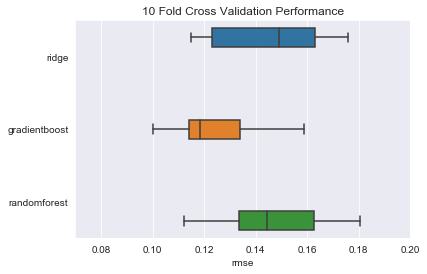

In [35]:
tmp = pd.melt(pd.DataFrame(score))

sns.boxplot(y = "variable",
            x = "value",
            hue = "variable",
            data = tmp,
           orient = "h")

plt.ylabel("")
plt.xlabel("rmse")
plt.xlim(0.07, 0.2)
plt.title("10 Fold Cross Validation Performance")
plt.legend().remove()
plt.savefig("../fig/model_cv", bbox_inches = "tight")

### Weight Coefficients from Regression

In [36]:
coef = ridge_fit.named_steps["ridgecv"].coef_
coef_series = pd.Series(coef, index = X_train.columns)

In [37]:
data = X_train.copy()
coef = ridge_fit.named_steps["ridgecv"].coef_

for col in X_train.columns:
    weights = coef_series.loc[col]
    data[col] = data[col] * weights
    
order = pd.melt(data).groupby("variable").agg(np.median).sort_values(by = "value").index

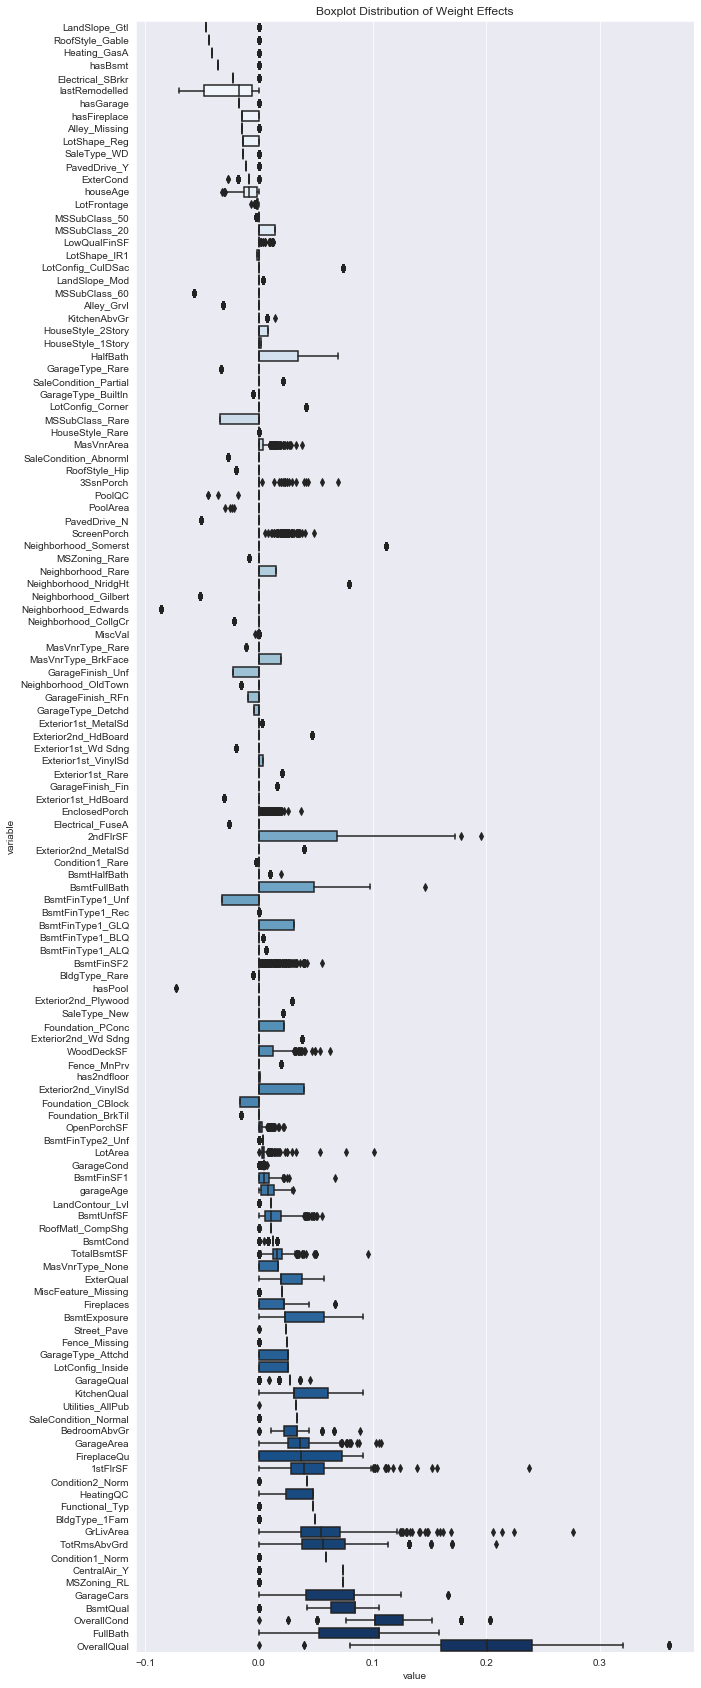

In [38]:
sns.set_style("darkgrid")

plt.figure(figsize = (10,30))
sns.boxplot(y = "variable", x = "value",
            data= pd.melt(data),
            palette="Blues", 
            order = order)
plt.title("Boxplot Distribution of Weight Effects")
plt.savefig("../fig/ridge_coef", bbox_inches = "tight")

## Trees Model

In [40]:
gbr_fit = gbr.fit(X_train, np.log1p(y_train))
rf_fit = rf.fit(X_train, np.log1p(y_train))

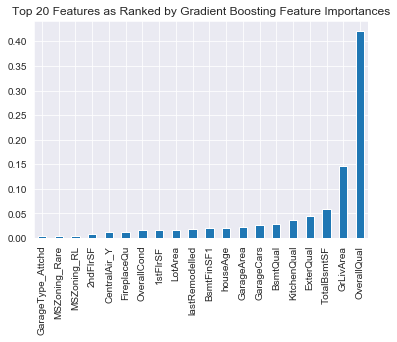

In [48]:
pd.Series(gbr_fit.feature_importances_, index = X_train.columns)\
.sort_values()\
.tail(20)\
.plot(kind = "bar")

plt.title("Top 20 Features as Ranked by Gradient Boosting Feature Importances")
plt.savefig("../fig/gbr_fit", bbox_inches = "tight")

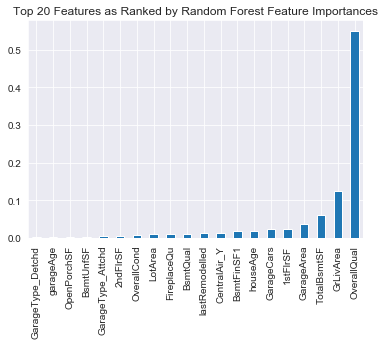

In [47]:
pd.Series(rf_fit.feature_importances_, index = X_train.columns)\
.sort_values()\
.tail(20)\
.plot(kind = "bar")

plt.title("Top 20 Features as Ranked by Random Forest Feature Importances")
plt.savefig("../fig/rf_fit", bbox_inches = "tight")

## Predicted vs Target Variable

In [51]:
sklearn.metrics.r2_score(np.exp(gbr_fit.predict(X_test)), y_test)

0.8498148377112644

In [52]:
sklearn.metrics.r2_score(np.exp(rf_fit.predict(X_test)), y_test)

0.7959047373418742

In [53]:
sklearn.metrics.r2_score(np.exp(ridge_fit.predict(X_test)), y_test)

0.8418022677884706

In [61]:
x = np.exp(rf_fit.predict(X_test))
y = y_test

In [140]:
def plot_residual(model, X_test, y_test, model_name):
    x = np.exp(model.predict(X_test))
    y = y_test
    sns.residplot(x, y, lowess = True, line_kws={'color':'red', 'linestyle':'-.'})
    rmse = np.sqrt(sklearn.metrics.mean_squared_error(np.exp(model.predict(X_test)), y_test))
    plt.title("RMSE: {0:.2f}".format(rmse))
    plt.ylabel("Standardized Residuals")
    plt.xlabel("Predicted Sale Price")
    plt.savefig("../fig/{}".format(model_name), bbox_inches = "tight")
    
def plot_linear_result(model, X_test, y_test, model_name):
    x = np.exp(model.predict(X_test))
    y = y_test
    sns.regplot(x, y, line_kws={'color':'red', 'linestyle':'-.'})
    r2_score = sklearn.metrics.r2_score(np.exp(model.predict(X_test)), y_test)
    plt.title("Validation Set R2-Score: {0:.2f}".format(r2_score))
    plt.ylabel("True Sale Price")
    plt.xlabel("Predicted Sale Price")
    plt.savefig("../fig/{}".format(model_name), bbox_inches = "tight")

### Ridge Regression Results

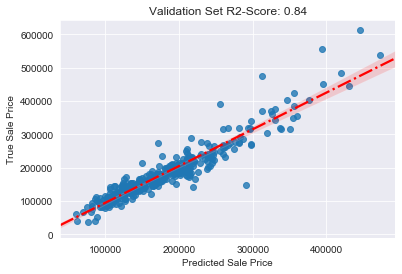

In [141]:
plot_linear_result(ridge_fit, X_test, y_test, "ridge_plot")

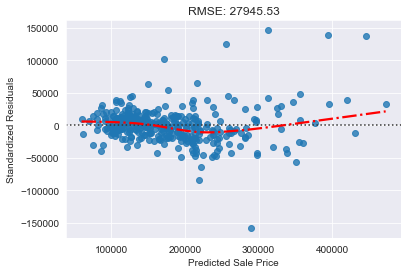

In [142]:
plot_residual(ridge_fit, X_test, y_test, "ridge_plot")

## Random Forest Prediction Results

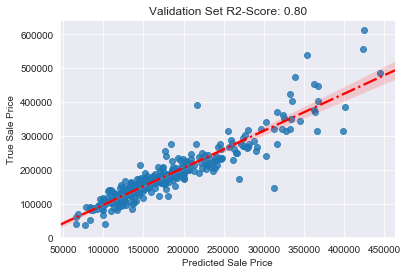

In [143]:
plot_linear_result(rf_fit, X_test, y_test, "rf_plot")

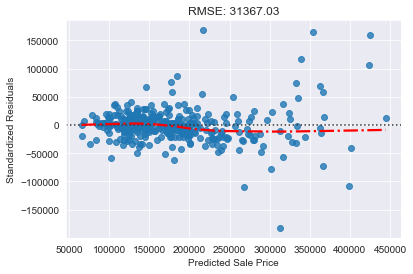

In [145]:
plot_residual(rf_fit, X_test, y_test, "rf_resid")

### Plot Gradient Boosting Regression

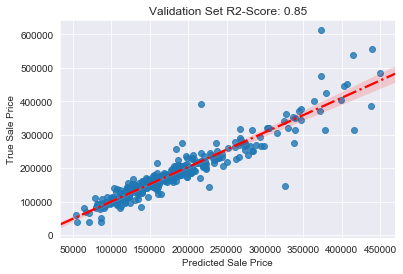

In [146]:
plot_linear_result(gbr_fit, X_test, y_test, "gb_plot")

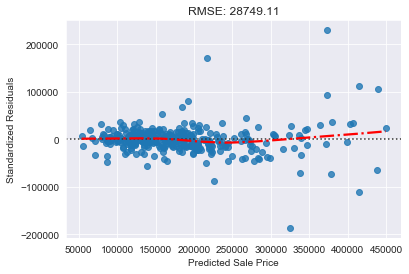

In [147]:
plot_residual(gbr_fit, X_test, y_test, "gb_resid")